In [5]:
import numpy as np
from scipy import signal
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\isuis\\projects\\00_Python\\online_gmm\\src\\utils.py'>

## ホワイトノイズの作成

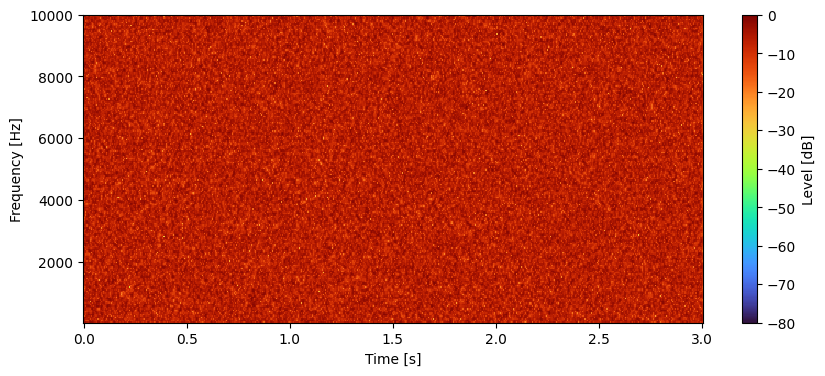

In [6]:
FS = 48000
duration = 3
samples = int(FS * duration)
wn = np.random.normal(0, 1, samples)

utils.plot_spectrogram(wn, FS)

## フィルタ

c:\Users\isuis\projects\00_Python\online_gmm\src\utils.py:17: RuntimeWarning: divide by zero encountered in log10
  Z_db = 10 * np.log10(Z / np.max(Z))


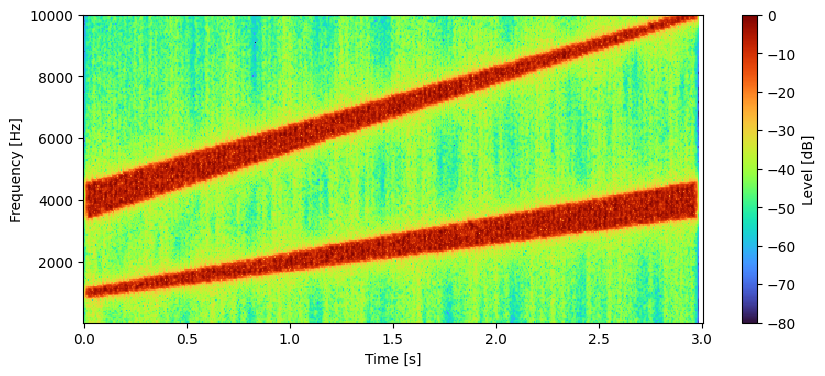

In [7]:
frame_len = int(0.05 * FS)
hop = frame_len // 2
window = np.hanning(frame_len)

n_frames = (samples - frame_len) // hop

numtaps = 1024
nyq = FS / 2.0

# 周波数トラジェクトリ
f1_traj = np.linspace(1000, 4000, n_frames)   # 1k -> 4k
f2_traj = np.linspace(4000, 10000, n_frames)  # 4k -> 10k

# bandwidthトラジェクトリ
bw1_traj = np.linspace(150.0, 1000.0, n_frames)   # 例: 150Hz -> 800Hz
bw2_traj = np.linspace(1000.0, 100.0, n_frames)   # 例: 600Hz -> 200Hz（逆に狭める）

def band_edges(fc, bw, margin=10.0):
    """[lo, hi] を安全に切り出し（最小限の簡易クランプ）"""
    bw = max(float(bw), 1.0)
    lo = max(margin, fc - bw/2.0)
    hi = min(nyq - margin, fc + bw/2.0)
    if hi <= lo:
        lo = max(margin, min(fc - 0.5*margin, nyq - margin*1.5))
        hi = lo + margin
    return lo, hi
# -----------------------------

wn_dynamic = np.zeros(samples)

for i in range(n_frames):
    start = i * hop
    end = start + frame_len
    x = wn[start:end] * window

    # --- フィルタ1（bwをフレームごとに変更） ---
    bw1 = bw1_traj[i]
    lo1, hi1 = band_edges(f1_traj[i], bw1)
    bp1 = signal.firwin(numtaps, [lo1, hi1], pass_zero=False, fs=FS)

    # --- フィルタ2（bwをフレームごとに変更） ---
    bw2 = bw2_traj[i]
    lo2, hi2 = band_edges(f2_traj[i], bw2)
    bp2 = signal.firwin(numtaps, [lo2, hi2], pass_zero=False, fs=FS)

    # 合成して適用
    fir = bp1 + bp2
    y = signal.lfilter(fir, 1.0, x)

    # Overlap-Add
    wn_dynamic[start:end] += y[:frame_len] * window

utils.plot_spectrogram(wn_dynamic, FS)

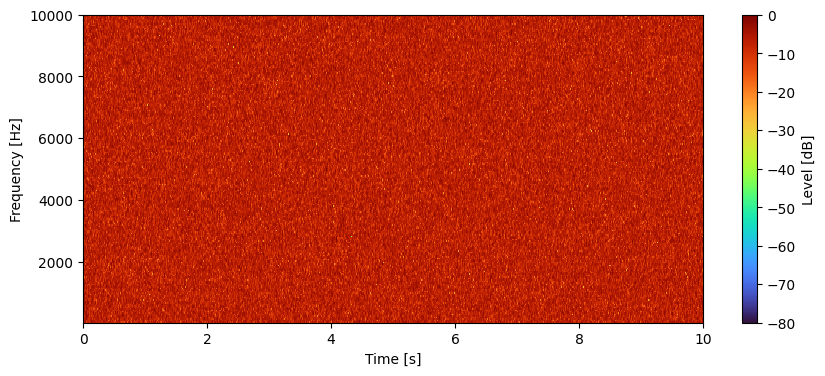

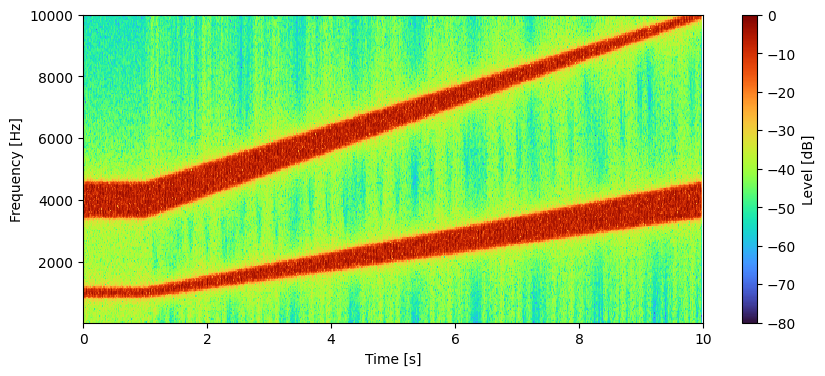

In [19]:
FS = 48000
DURATION_SEC = 10.0
STATIC_SEC   = 1.0           # 最初の固定区間（秒）

# 窓・フレーム
FRAME_MS   = 50.0            # フレーム長（ms）
HOP_RATIO  = 0.5             # ホップ比（0.5 = 50% overlap）

# FIR
NUMTAPS = 1024
EPS_HZ  = 1.0                # 端(0/Nyq)の余白(Hz)
BW_MIN  = 5.0                # 極端に狭い帯域の救済(Hz)

# 後半トラジェクトリ（固定期はこの START 値と同じにする）
F1_START, F1_END   = 1000.0,  4000.0     # 1k → 4k
F2_START, F2_END   = 4000.0, 10000.0     # 4k → 10k
BW1_START, BW1_END = 150.0,  1000.0      # 150 → 1000 Hz
BW2_START, BW2_END = 1000.0, 100.0       # 1000 → 100 Hz
# =========================

# ノイズ
samples = int(FS * DURATION_SEC)
wn = np.random.normal(0, 1, samples)

# フレーム
frame_len = int((FRAME_MS/1000.0) * FS)
hop       = int(frame_len * HOP_RATIO)
window    = np.hanning(frame_len)
n_frames  = (samples - frame_len) // hop

# 境界（end > STATIC_SEC を後半扱い）
split_sample = int(STATIC_SEC * FS)
frame_starts = np.arange(n_frames) * hop
frame_ends   = frame_starts + frame_len
post_indices = np.where(frame_ends > split_sample)[0]
start_move_idx = int(post_indices[0]) if post_indices.size > 0 else n_frames
n_move = max(n_frames - start_move_idx, 0)

nyq = 0.5 * FS

def band_edges(fc, bw, eps=EPS_HZ, bw_min=BW_MIN):
    """±bw/2 だけ、端とゼロ幅の最小限ガード。"""
    bw = max(float(bw), bw_min)
    half = 0.5 * bw
    lo = max(eps, fc - half)
    hi = min(nyq - eps, fc + half)
    if hi <= lo:
        hi = min(nyq - eps, lo + max(bw_min, 2*eps))
    return lo, hi

def make_two_band_fir(fc1, bw1, fc2, bw2):
    lo1, hi1 = band_edges(fc1, bw1)
    lo2, hi2 = band_edges(fc2, bw2)
    bp1 = signal.firwin(NUMTAPS, [lo1, hi1], pass_zero=False, fs=FS)
    bp2 = signal.firwin(NUMTAPS, [lo2, hi2], pass_zero=False, fs=FS)
    return bp1 + bp2

# ★ 固定期のFIRは「START値」で設計（= 後半トラジェクトリの開始と同じ）
fir_fixed = make_two_band_fir(F1_START, BW1_START, F2_START, BW2_START)

# 後半トラジェクトリ（フレーム数に合わせる）
if n_move > 0:
    f1_traj  = np.linspace(F1_START,  F1_END,  n_move)
    f2_traj  = np.linspace(F2_START,  F2_END,  n_move)
    bw1_traj = np.linspace(BW1_START, BW1_END, n_move)
    bw2_traj = np.linspace(BW2_START, BW2_END, n_move)

wn_out = np.zeros(samples)

for i in range(n_frames):
    start = i * hop
    end   = start + frame_len
    x = wn[start:end] * window

    if i < start_move_idx:
        # 最初の STATIC_SEC は「START値と同じ固定バンド」
        y = signal.lfilter(fir_fixed, 1.0, x)
    else:
        # 後半：トラジェクトリ適用
        j = i - start_move_idx   # 後半中の相対 index
        fir = make_two_band_fir(f1_traj[j], bw1_traj[j], f2_traj[j], bw2_traj[j])
        y = signal.lfilter(fir, 1.0, x)

    wn_out[start:end] += y[:frame_len] * window

utils.plot_spectrogram(wn, FS)      # 元
utils.plot_spectrogram(wn_out, FS)  # 加工後
